In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os
import noisereduce as nr
torch.manual_seed(10)

/anaconda/envs/py36/lib/python3.6/site-packages/noisereduce/noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [8]:
import pandas as pd
audio = pd.read_csv('audio_df_improvised.csv')

audio.reset_index(inplace=True)
audio.head()

,index,start_time,end_time,wav_file,emotion,val,act,dom
0,0,6.2901,8.2357,Ses01F_impro01_F000,neu,2.5,2.5,2.5
1,1,10.0100,11.3925,Ses01F_impro01_F001,neu,2.5,2.5,2.5
2,2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5
3,3,27.4600,31.4900,Ses01F_impro01_F005,neu,2.5,3.5,2.0
4,4,85.2700,88.0200,Ses01F_impro01_F012,ang,2.0,3.5,3.5


In [25]:
# audio['duration'] = np.array(audio.end_time) - np.array(audio.start_time)
# audio = audio[ audio['duration']>2 ]
# audio.to_csv ('audio_morethan2_duration.csv', index = False, header=True)

In [26]:
# audio = pd.read_csv('audio_morethan2_duration.csv')
# audio.reset_index(inplace=True)
# audio.head()

,level_0,index,start_time,end_time,wav_file,emotion,val,act,dom,duration
0,0,2,14.8872,18.0175,Ses01F_impro01_F002,neu,2.5,2.5,2.5,3.1303
1,1,3,27.4600,31.4900,Ses01F_impro01_F005,neu,2.5,3.5,2.0,4.0300
2,2,4,85.2700,88.0200,Ses01F_impro01_F012,ang,2.0,3.5,3.5,2.7500
3,3,5,97.8900,102.9600,Ses01F_impro01_F014,neu,2.5,3.5,3.5,5.0700
4,4,6,87.1500,94.3900,Ses01F_impro01_M011,ang,2.0,4.0,4.0,7.2400


In [9]:
# We split the dataframe into train and test segments
from sklearn.utils import shuffle
train = audio[:2212]
train = shuffle(train)
valid = audio[2212:]

In [36]:
def get_melspectrogram_db(file_path, med_duration ,sr=None, n_fft=2048, hop_length=256, n_mels=128, fmin=100, fmax=15000, top_db=80):
    med_duration = int(np.floor(med_duration))
    wav,sr = librosa.load(file_path,sr=sr)
    wav = nr.reduce_noise(audio_clip=wav, noise_clip=wav, verbose=False)
    if wav.shape[0]<(med_duration*sr):
        wav=np.pad(wav,int( np.ceil( ((med_duration*sr)-wav.shape[0])/2 ) ),mode='constant', constant_values=(0, 0))
    else:
        wav=wav[:(med_duration*sr)]
    spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels)
#     librosa.decompose.nn_filter(spec, aggregate=np.median, metric='cosine')
    spec_db=librosa.power_to_db(spec)
    return spec_db

In [15]:
def spec_to_image(spec, eps=1e-6):
    mean = spec.mean()
    std = spec.std()
    spec_norm = (spec - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)

    return spec_scaled

In [13]:
!pwd

/data/home/advaitmb/notebooks/Saaket/speech-emotion-recognition


(128, 251)

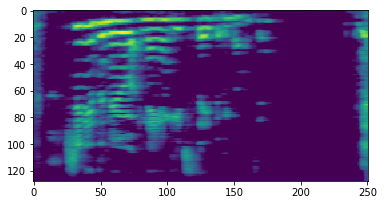

In [37]:
plt.imshow(spec_to_image(get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[56] + '.wav', 4 )))
get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[0] + '.wav', 4 ).shape

tensor([[[  1.,  10.,  11.,  15.,   9., 100.],
         [  2.,  11.,  12.,  16.,   9., 100.]],

        [[  2.,  11.,  12.,  16.,   9., 100.],
         [  3.,  12.,  13.,  17.,   9., 100.]]])
therefore, with dimensions (2=batch_size, 2=seq_length, 6=input_size).

where input is of shape(seq_len, batch, input_size)

In [46]:
x = (torch.from_numpy(spec_to_image(get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[1000] + '.wav', 4 )).T)).unsqueeze(0)

rnn(x)


RuntimeError: Expected object of scalar type Byte but got scalar type Float for argument #2 'mat2'

In [50]:
rnn = nn.LSTM(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
x= torch.from_numpy(spec_to_image(get_melspectrogram_db('/data/home/advaitmb/datasets/sentences/' + audio.wav_file[1000] + '.wav', 4 )).T).unsqueeze(0)
print(x.shape)
out, _ = rnn(x)
print(out.reshape(out.size(0), -1).shape)


torch.Size([1, 251, 128])
torch.Size([1, 32128])


In [38]:
class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(( get_melspectrogram_db(file_path, 4).T ))
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [39]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

  0%|          | 2/2212 [00:00<02:37, 14.05it/s]

['ang', 'hap', 'neu', 'sad']


  0%|          | 2/731 [00:00<00:38, 19.18it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:44<00:00, 16.56it/s]


In [40]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(128, hidden_size = 64, num_layers=2, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(251*64*2, 64)
        self.fc2 = nn.Linear(64, 4)
        
    def forward(self, x):
        x,_ = self.rnn(x)
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [41]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

In [25]:
net = Network()
net = net.to(device)

In [43]:
train_loader.dataset.data[1].shape

(251, 128)

In [42]:
def setlr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

def lr_decay(optimizer, epoch):
    if epoch%10==0:
        new_lr = learning_rate / (10**(epoch//10))
        optimizer = setlr(optimizer, new_lr)
        print("Changed learning rate to {}".format(new_lr))
    return optimizer

In [44]:
def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1,epochs+1)):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


        print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print("Epoch - {} Valid-Loss : {} Valid-Accuracy : {}".format(epoch, np.mean(valid_losses[-1]), accuracy ))
        



In [45]:
learning_rate = 2e-5
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.01)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]

In [46]:
train_model(net, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.1719778333391462


  5%|▌         | 1/20 [00:07<02:21,  7.47s/it]

Epoch - 1 Valid-Loss : 1.2192200992418372 Valid-Accuracy : 0.5034199726402189
Epoch - 2 Train-Loss : 1.1390072056225369


 10%|█         | 2/20 [00:14<02:12,  7.36s/it]

Epoch - 2 Valid-Loss : 1.2018405095390652 Valid-Accuracy : 0.5430916552667578
Epoch - 3 Train-Loss : 1.1179372072219849


 15%|█▌        | 3/20 [00:21<02:03,  7.28s/it]

Epoch - 3 Valid-Loss : 1.226969319841136 Valid-Accuracy : 0.5020519835841313
Epoch - 4 Train-Loss : 1.1126976702894484


 20%|██        | 4/20 [00:28<01:55,  7.23s/it]

Epoch - 4 Valid-Loss : 1.1950005344722583 Valid-Accuracy : 0.5554035567715458
Epoch - 5 Train-Loss : 1.1101831989628927


 25%|██▌       | 5/20 [00:35<01:48,  7.20s/it]

Epoch - 5 Valid-Loss : 1.200543911560722 Valid-Accuracy : 0.5088919288645691
Epoch - 6 Train-Loss : 1.0978545469897134


 30%|███       | 6/20 [00:43<01:40,  7.18s/it]

Epoch - 6 Valid-Loss : 1.1901778604673303 Valid-Accuracy : 0.5581395348837209
Epoch - 7 Train-Loss : 1.0910514261041369


 35%|███▌      | 7/20 [00:50<01:33,  7.16s/it]

Epoch - 7 Valid-Loss : 1.1873185064481653 Valid-Accuracy : 0.5622435020519836
Epoch - 8 Train-Loss : 1.0805894110883985


 40%|████      | 8/20 [00:57<01:25,  7.15s/it]

Epoch - 8 Valid-Loss : 1.2085576057434082 Valid-Accuracy : 0.521203830369357
Epoch - 9 Train-Loss : 1.0792598818029677


 45%|████▌     | 9/20 [01:04<01:18,  7.15s/it]

Epoch - 9 Valid-Loss : 1.2184535005818242 Valid-Accuracy : 0.5102599179206566
Changed learning rate to 2.0000000000000003e-06
Epoch - 10 Train-Loss : 1.069644934790475


 50%|█████     | 10/20 [01:11<01:11,  7.15s/it]

Epoch - 10 Valid-Loss : 1.193997455679852 Valid-Accuracy : 0.5389876880984952
Epoch - 11 Train-Loss : 1.0668810537883213


 55%|█████▌    | 11/20 [01:18<01:04,  7.13s/it]

Epoch - 11 Valid-Loss : 1.1933472933976546 Valid-Accuracy : 0.5403556771545828
Epoch - 12 Train-Loss : 1.0677506932190486


 60%|██████    | 12/20 [01:25<00:57,  7.13s/it]

Epoch - 12 Valid-Loss : 1.1935150260510652 Valid-Accuracy : 0.5403556771545828
Epoch - 13 Train-Loss : 1.0625212626797813


 65%|██████▌   | 13/20 [01:32<00:49,  7.13s/it]

Epoch - 13 Valid-Loss : 1.1950822446657263 Valid-Accuracy : 0.5362517099863201
Epoch - 14 Train-Loss : 1.0660860214914594


 70%|███████   | 14/20 [01:40<00:42,  7.13s/it]

Epoch - 14 Valid-Loss : 1.194730898608332 Valid-Accuracy : 0.533515731874145
Epoch - 15 Train-Loss : 1.0625592640468053


 75%|███████▌  | 15/20 [01:47<00:35,  7.11s/it]

Epoch - 15 Valid-Loss : 1.1926310425219329 Valid-Accuracy : 0.5430916552667578
Epoch - 16 Train-Loss : 1.0648209248270308


 80%|████████  | 16/20 [01:54<00:28,  7.12s/it]

Epoch - 16 Valid-Loss : 1.1898632827012434 Valid-Accuracy : 0.5526675786593708
Epoch - 17 Train-Loss : 1.0683996447495052


 85%|████████▌ | 17/20 [02:01<00:21,  7.12s/it]

Epoch - 17 Valid-Loss : 1.1932113948075667 Valid-Accuracy : 0.5417236662106704
Epoch - 18 Train-Loss : 1.0621749937534333


 90%|█████████ | 18/20 [02:08<00:14,  7.12s/it]

Epoch - 18 Valid-Loss : 1.1909380218257075 Valid-Accuracy : 0.5458276333789329
Epoch - 19 Train-Loss : 1.062884521484375


 95%|█████████▌| 19/20 [02:15<00:07,  7.12s/it]

Epoch - 19 Valid-Loss : 1.1906652917032656 Valid-Accuracy : 0.5458276333789329
Changed learning rate to 2.0000000000000002e-07
Epoch - 20 Train-Loss : 1.0572853990963527


100%|██████████| 20/20 [02:22<00:00,  7.14s/it]

Epoch - 20 Valid-Loss : 1.1904672384262085 Valid-Accuracy : 0.5471956224350205


In [68]:
from torchvision import models
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# resnet18 = nn.Sequential(*list(resnet18.children())[:-2])
# # print(resnet18)
resnet18.fc = nn.Linear(512, 128, bias=True)
# i = torch.randn(32, 1, 251, 128)
# a = resnet18(i)
# print(a.shape)
# a = a.permute(0,2,1,3)
# a = a.reshape( a.shape[0], a.shape[1], a.shape[2]*a.shape[3] )
# a.shape
print(resnet18)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [207]:
rnn = nn.GRU(2048, hidden_size = 64, num_layers=1, bidirectional=True, batch_first=True)
x = torch.randn(1,8,2048)
x,_ = rnn(x)
x.shape

torch.Size([1, 8, 128])

In [238]:
layers = [ 1, 32, 64, 128, 64, 32 ]
cnn = [ nn.Conv2d(layers[l-1],layers[l], 5, 2, 1 ) for l in range(1, len(layers)) ]
bn = [ nn.BatchNorm2d(layers[l]) for l in range(1, len(layers)) ]
# print(cnn)
# print(bn)
# x = torch.randn(32, 1, 251, 128)
for la in range(len(cnn)):
    x = cnn[la](x)
    x = bn[la](x)
    
x

RuntimeError: Given groups=1, weight of size 32 1 5 5, expected input[32, 32, 125, 63] to have 1 channels, but got 32 channels instead

In [55]:
class CRNN(nn.Module):
    def __init__(self):
        super().__init__()
        
#         self.conv1 = nn.Conv2d(1, 32, 5, 2, 1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 64, 3 , 2, 1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.conv5 = nn.Conv2d(64, 32, 3, 2, 1)
        self.cnn = resnet18
        self.rnn = nn.GRU(2048, hidden_size = 64, num_layers=1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(8*128, 4)


    def conv(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.permute(0,2,1,3)
        x = x.reshape( x.shape[0], x.shape[1], x.shape[2]*x.shape[3] )
        x,_ = self.rnn(x)
        x = x.reshape(x.size(0), -1)
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [56]:
crnn = CRNN()
crnn.to(device)
print('done')

done


In [57]:
a = torch.randn(32, 1, 251, 128).to(device)
crnn(a)

tensor([[0.3114, 0.2048, 0.2416, 0.2422],
        [0.3127, 0.2347, 0.2232, 0.2293],
        [0.3113, 0.2175, 0.2141, 0.2571],
        [0.2996, 0.1960, 0.2485, 0.2559],
        [0.3498, 0.2207, 0.2096, 0.2199],
        [0.2895, 0.2225, 0.2374, 0.2507],
        [0.3408, 0.2192, 0.2297, 0.2104],
        [0.3554, 0.1855, 0.2090, 0.2502],
        [0.3370, 0.1937, 0.2343, 0.2350],
        [0.3293, 0.2019, 0.2325, 0.2362],
        [0.3560, 0.1969, 0.2540, 0.1931],
        [0.3448, 0.1820, 0.2480, 0.2251],
        [0.3342, 0.2078, 0.2279, 0.2301],
        [0.3469, 0.2127, 0.2093, 0.2311],
        [0.3184, 0.1812, 0.2580, 0.2423],
        [0.3276, 0.2204, 0.2436, 0.2084],
        [0.3643, 0.2146, 0.2365, 0.1847],
        [0.3114, 0.2050, 0.2373, 0.2463],
        [0.2897, 0.2127, 0.2482, 0.2494],
        [0.3347, 0.2114, 0.2243, 0.2296],
        [0.3235, 0.2020, 0.2357, 0.2388],
        [0.3418, 0.1868, 0.2421, 0.2294],
        [0.3621, 0.1958, 0.2125, 0.2296],
        [0.3447, 0.1894, 0.2606, 0

In [58]:
class IEMOCAP(Dataset):
    def __init__(self, base, df, in_col, out_col):
        self.df = df
        self.data = []
        self.labels = []
        self.c2i={}
        self.i2c={}
        self.categories = sorted(df[out_col].unique())
        print(self.categories)
        for i, category in enumerate(self.categories):
            self.c2i[category]=i
            self.i2c[i]=category
        for ind in tqdm(range(len(df))):
            row = df.iloc[ind]
            
            #If all files are stored in a folder named sentences
            file_path = base + '/' + row[in_col] + '.wav'
            
            
            self.data.append(( spec_to_image(get_melspectrogram_db(file_path, 4)).T[np.newaxis,...] ))
            self.labels.append(self.c2i[row['emotion']])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [59]:
train_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', train, 'wav_file', 'emotion')
valid_data = IEMOCAP('/data/home/advaitmb/datasets/sentences', valid, 'wav_file', 'emotion')
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

  0%|          | 2/2212 [00:00<02:37, 14.03it/s]

['ang', 'hap', 'neu', 'sad']


  0%|          | 2/731 [00:00<00:40, 17.99it/s]

['ang', 'hap', 'neu', 'sad']


100%|██████████| 731/731 [00:44<00:00, 16.60it/s]


In [62]:
learning_rate = 2e-7
# optimizer = optim.Adam(crnn.parameters(), lr=learning_rate, weight_decay=0.01)
epochs = 10
# loss_fn = nn.CrossEntropyLoss()
# train_losses=[]
# valid_losses=[]


In [63]:
train_model(crnn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.7657878773553031


 10%|█         | 1/10 [00:11<01:47, 12.00s/it]

Epoch - 1 Valid-Loss : 1.1560689314551975 Valid-Accuracy : 0.5991792065663475
Epoch - 2 Train-Loss : 0.7602540671825408


 20%|██        | 2/10 [00:23<01:35, 11.98s/it]

Epoch - 2 Valid-Loss : 1.1568336538646533 Valid-Accuracy : 0.5950752393980848
Epoch - 3 Train-Loss : 0.7608691734927041


 30%|███       | 3/10 [00:35<01:23, 11.96s/it]

Epoch - 3 Valid-Loss : 1.1625111906424812 Valid-Accuracy : 0.5909712722298222
Epoch - 4 Train-Loss : 0.7605856316430228


 40%|████      | 4/10 [00:47<01:11, 11.98s/it]

Epoch - 4 Valid-Loss : 1.156731849131377 Valid-Accuracy : 0.6032831737346102
Epoch - 5 Train-Loss : 0.7604665628501347


 50%|█████     | 5/10 [00:59<01:00, 12.01s/it]

Epoch - 5 Valid-Loss : 1.1577506998310918 Valid-Accuracy : 0.5964432284541724
Epoch - 6 Train-Loss : 0.7618333390780858


 60%|██████    | 6/10 [01:12<00:48, 12.03s/it]

Epoch - 6 Valid-Loss : 1.1657061265862507 Valid-Accuracy : 0.5841313269493844
Epoch - 7 Train-Loss : 0.7611525441919055


 70%|███████   | 7/10 [01:24<00:36, 12.09s/it]

Epoch - 7 Valid-Loss : 1.1616346265958704 Valid-Accuracy : 0.5896032831737346
Epoch - 8 Train-Loss : 0.7612968598093305


 80%|████████  | 8/10 [01:36<00:24, 12.12s/it]

Epoch - 8 Valid-Loss : 1.155289738074593 Valid-Accuracy : 0.6073871409028728
Epoch - 9 Train-Loss : 0.7605901181697845


 90%|█████████ | 9/10 [01:48<00:12, 12.12s/it]

Epoch - 9 Valid-Loss : 1.1604523969733196 Valid-Accuracy : 0.5978112175102599
Changed learning rate to 2e-08
Epoch - 10 Train-Loss : 0.7622888045651572


100%|██████████| 10/10 [02:00<00:00, 12.07s/it]

Epoch - 10 Valid-Loss : 1.1543341978736545 Valid-Accuracy : 0.6019151846785226


In [65]:
nn.GRUCell??

In [76]:
x = torch.randn(32, 1, 251, 128)
x = resnet18(x)
print(x.shape)
# rnn = nn.GRUCell(128, 32)
# x = rnn(x)
# x.shape
# fc2 = nn.Linear(32, 4)
# x = fc2(x)
# x.shape

torch.Size([32, 128])


In [85]:
class WrongNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        
#         self.conv1 = nn.Conv2d(1, 32, 5, 2, 1)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = nn.Conv2d(32, 64, 3, 2, 1)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = nn.Conv2d(64, 128, 3, 2, 1)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.conv4 = nn.Conv2d(128, 64, 3 , 2, 1)
#         self.bn4 = nn.BatchNorm2d(64)
#         self.conv5 = nn.Conv2d(64, 32, 3, 2, 1)
        self.cnn = resnet18
        

        self.rnn = nn.GRUCell(128, hidden_size = 64)
        self.fc = nn.Linear(64, 4)


    def conv(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        return x
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.rnn(x)
        x = F.softmax(self.fc(x), dim=1)
        return x

In [86]:
wn = WrongNetwork()
wn.to(device)

WrongNetwork(
  (cnn): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [87]:
def train_model(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
    
    for epoch in tqdm(range(1,epochs+1)):
        
        model.train()
        batch_losses=[]
        if change_lr:
            optimizer = change_lr(optimizer, epoch)
        for i, data in enumerate(train_loader):
            x, y = data
            optimizer.zero_grad()
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            loss.backward()
            batch_losses.append(loss.item())
            optimizer.step()
        train_losses.append(batch_losses)


        print("Epoch - {} Train-Loss : {}".format(epoch, np.mean(train_losses[-1])))
        model.eval()
        batch_losses=[]
        trace_y = []
        trace_yhat = []
        for i, data in enumerate(valid_loader):
            x, y = data
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            y_hat = model(x)
            loss = loss_fn(y_hat, y)
            trace_y.append(y.cpu().detach().numpy())
            trace_yhat.append(y_hat.cpu().detach().numpy())      
            batch_losses.append(loss.item())

        valid_losses.append(batch_losses)
        trace_y = np.concatenate(trace_y)
        trace_yhat = np.concatenate(trace_yhat)
        accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
        print("Epoch - {} Valid-Loss : {} Valid-Accuracy : {}".format(epoch, np.mean(valid_losses[-1]), accuracy ))
        




In [ ]:
learning_rate = 2e-7
optimizer = optim.Adam(wn.parameters(), lr=learning_rate, weight_decay=0.01)
epochs = 10
loss_fn = nn.CrossEntropyLoss()
train_losses=[]
valid_losses=[]



In [88]:
train_model(wn, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, lr_decay)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 1.3941045658929008


 10%|█         | 1/10 [00:11<01:46, 11.84s/it]

Epoch - 1 Valid-Loss : 1.3978080438530964 Valid-Accuracy : 0.11491108071135431
Epoch - 2 Train-Loss : 1.3938811336244856


 20%|██        | 2/10 [00:23<01:34, 11.81s/it]

Epoch - 2 Valid-Loss : 1.3975042934003084 Valid-Accuracy : 0.12859097127222982
Epoch - 3 Train-Loss : 1.3936347688947406


 30%|███       | 3/10 [00:35<01:22, 11.79s/it]

Epoch - 3 Valid-Loss : 1.3974374791850215 Valid-Accuracy : 0.12311901504787962
Epoch - 4 Train-Loss : 1.3941247429166521


 40%|████      | 4/10 [00:47<01:10, 11.78s/it]

Epoch - 4 Valid-Loss : 1.3976746849391772 Valid-Accuracy : 0.12038303693570451
Epoch - 5 Train-Loss : 1.3942324229649135


 50%|█████     | 5/10 [00:58<00:58, 11.78s/it]

Epoch - 5 Valid-Loss : 1.3980843917183254 Valid-Accuracy : 0.11764705882352941
Epoch - 6 Train-Loss : 1.3942568012646266


 60%|██████    | 6/10 [01:10<00:47, 11.78s/it]

Epoch - 6 Valid-Loss : 1.3976275558057039 Valid-Accuracy : 0.12038303693570451
Epoch - 7 Train-Loss : 1.3940265774726868


 70%|███████   | 7/10 [01:22<00:35, 11.77s/it]

Epoch - 7 Valid-Loss : 1.397538195485654 Valid-Accuracy : 0.12448700410396717
Epoch - 8 Train-Loss : 1.3941379070281983


 80%|████████  | 8/10 [01:34<00:23, 11.77s/it]

Epoch - 8 Valid-Loss : 1.3973677624826846 Valid-Accuracy : 0.12175102599179206
Epoch - 9 Train-Loss : 1.393904003075191


 90%|█████████ | 9/10 [01:45<00:11, 11.76s/it]

Epoch - 9 Valid-Loss : 1.3978221675624019 Valid-Accuracy : 0.11080711354309165
Changed learning rate to 2e-08
Epoch - 10 Train-Loss : 1.3940645609583173


100%|██████████| 10/10 [01:57<00:00, 11.77s/it]

Epoch - 10 Valid-Loss : 1.3973237587058025 Valid-Accuracy : 0.12722298221614228
